In [ ]:
# run this cell if you are in colab with a single notebook opened, otherwise ignore this cell

!git clone https://github.com/CowboyPhilip/HPML-Energy-Efficient-LLM
%cd HPML-Energy-Efficient-LLM 
!ls

import sys
import os
sys.path.append("/content/HPML-Energy-Efficient-LLM")

In [ ]:
# -*- coding: utf-8 -*-
"""DeepSeek Energy Consumption Benchmark

This notebook measures energy consumption and carbon footprint of LLMs with
different quantization methods (FP16, INT8, INT4).
Optimized for Google Colab A100 GPU (40GB).
"""

In [1]:
# Cell 1: Install the correct Zeus package in colab
!pip install zeus-ml  # The correct package name is zeus-ml, not zeus
!pip install --upgrade pip setuptools
!pip install transformers \
            bitsandbytes \
            zeus-ml \
            torch \
            datasets \
            evaluate \
            scikit-learn \
            geocoder \
            requests \
            flash-attn

In [1]:
# Cell 2: Environment setup and imports
import torch
import os
import numpy as np
from functools import partial
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorWithPadding
)
from zeus.monitor import ZeusMonitor
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import json
import geocoder
import requests
import matplotlib.pyplot as plt
import pandas as pd
import time
import gc

# Clear GPU cache
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Environment variables for better performance
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["ZEUS_DISABLE_AMD_SMI"] = "1"
os.environ["TRANSFORMERS_LLM_INT8_ENABLE_FP32_CPU_OFFLOAD"] = "1"

# Check GPU information
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU device: {torch.cuda.get_device_name(0)}")
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

/opt/conda/envs/vLLM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/rocm/lib/libamd_smi.so: cannot open shared object file: No such file or directory
Unable to find libamd_smi.so library try installing amd-smi-lib from your package manager
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: Tesla T4
GPU memory: 15.64 GB


In [2]:
# Cell 3: Memory management utilities
from utils.memory_utils import clean_memory, print_gpu_memory

In [3]:
# Cell 4: EnergyTracker and Carbon intensity estimation
from utils.energy_utils import EnergyTracker, get_carbon_intensity, joules_to_co2

In [4]:
# Cell 5: Model loading functions with memory optimization
from utils.load_llm import load_llm, load_classifier

In [5]:
# Cell 6: Text Generation Energy Benchmark
from utils.test_generation import compare_generation_energy, quick_test_generation

In [6]:
def convert_numpy(obj):
    """
    Recursively convert NumPy types to Python native types for JSON serialization.
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy array to list
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}  # Recursively convert dict
    elif isinstance(obj, list):
        return [convert_numpy(i) for i in obj]  # Recursively convert list
    else:
        return obj  # Return unchanged if not a NumPy type

In [7]:
# Cell 7: GLUE Task Energy Benchmarking, and GLUE benchmark with different quantization methods
from utils.test_glue import run_glue_energy_monitoring, test_quantized_models_on_glue

In [53]:
# Cell 8: Full Benchmark Function
def run_full_benchmark(model_name, run_fp16=False):
    """
    Run a full benchmark of both generation and GLUE tasks with different quantization modes

    Args:
        model_name: HuggingFace model name to benchmark
        run_fp16: Whether to include FP16 mode (memory intensive)

    Returns:
        Dictionary with benchmark results
    """
    print("="*80)
    print(f"RUNNING ENERGY BENCHMARK FOR {model_name}")
    print("="*80)
    results = {}

    # Determine modes to test
    modes = ['int8', 'int4']
    if run_fp16:
        modes.insert(0, 'fp16')  # Add fp16 at beginning if requested

    # Part 1: Text Generation Benchmark
    print("\n\n==== PART 1: TEXT GENERATION ENERGY BENCHMARK ====\n")
    prompt = "DeepSeek AI is an advanced open-source language model designed to power AI applications."
    generation_results = compare_generation_energy(
        model_name=model_name,
        prompt=prompt,
        quantization_modes=modes,
        verbose=True
    )
    results['generation'] = generation_results

    # Part 2: GLUE Tasks Benchmark
    print("\n\n==== PART 2: GLUE TASKS ENERGY BENCHMARK ====\n")
    glue_tasks = ['sst2']  # Just one task for memory efficiency
    glue_results = test_quantized_models_on_glue(
        model_name=model_name,
        tasks=glue_tasks,
        quantization_modes=modes,
        batch_size=1  # Single sample batch size
    )
    results['glue'] = glue_results

    # Final Summary
    print("\n\n==== FINAL SUMMARY ====\n")
    print("Comparison of Energy Efficiency Across Tasks and Quantization Modes:")

    # Get carbon intensity for final calculations
    carbon_intensity = get_carbon_intensity()

    # Calculate total energy and carbon footprint
    total_energy = {mode: 0.0 for mode in modes}

    # Add generation energy
    for mode in modes:
        if mode in generation_results and 'total_energy' in generation_results[mode]:
            total_energy[mode] += generation_results[mode]['total_energy']

    # Add GLUE energy
    for task in glue_tasks:
        for mode in modes:
            if mode in glue_results[task] and 'total_energy' in glue_results[task][mode]:
                total_energy[mode] += glue_results[task][mode]['total_energy']

    # Print total energy and carbon footprint
    print("\nTotal Energy Consumption:")
    for mode in modes:
        carbon = joules_to_co2(total_energy[mode], carbon_intensity)
        print(f"{mode.upper()}: {total_energy[mode]:.4f} J = {carbon:.6f} gCO2eq")

    # Calculate energy savings if we have fp16 data
    if 'fp16' in modes and total_energy['fp16'] > 0:
        baseline = total_energy['fp16']
        print("\nTotal Energy Savings:")
        for mode in ['int8', 'int4']:
            savings = 100 * (baseline - total_energy[mode]) / baseline
            print(f"{mode.upper()} saves {savings:.2f}% energy compared to FP16")
    elif len(modes) > 1:
        # If no fp16, compare to highest energy mode
        baseline_mode = max([m for m in modes if total_energy[m] > 0], key=lambda m: total_energy[m])
        baseline = total_energy[baseline_mode]
        print(f"\nTotal Energy Savings (compared to {baseline_mode.upper()}):")
        for mode in modes:
            if mode != baseline_mode and total_energy[mode] > 0:
                savings = 100 * (baseline - total_energy[mode]) / baseline
                print(f"{mode.upper()} saves {savings:.2f}% energy compared to {baseline_mode.upper()}")

    return results

In [8]:
# Cell 9: Results Visualization Functions
from utils.plot_utils import plot_component_energy, plot_energy_comparison

In [ ]:
# Cell 10: Main execution cell
"""
# Set model name
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"

# Choose one of the following options to run:

# Option 1: Quick single-mode test (fastest)
quick_test_generation(MODEL_NAME, quant_mode='int4')

# Option 2: Generation benchmark with INT8 and INT4 only
generation_results = compare_generation_energy(
    model_name=MODEL_NAME,
    prompt="DeepSeek AI is an advanced open-source language model designed to power AI applications.",
    quantization_modes=['int8', 'int4'],
    verbose=True
)
plot_energy_comparison({"generation": generation_results})
plot_component_energy({"generation": generation_results}, task_type='generation', quant_mode='int4')

# Option 3: GLUE benchmark with INT8 and INT4 only
glue_results = test_quantized_models_on_glue(
    model_name=MODEL_NAME,
    tasks=['sst2'],
    quantization_modes=['int8', 'int4'],
    batch_size=1
)
plot_energy_comparison({"glue": glue_results})
plot_component_energy({"glue": glue_results}, task_type='glue', quant_mode='int4')

# Option 4: Full benchmark
results = run_full_benchmark(MODEL_NAME, run_fp16=False)
"""

In [ ]:
# Cell 14: Usage Instructions
"""
# DeepSeek Energy Consumption Benchmark for Google Colab A100 (40GB)

This notebook measures energy consumption and carbon footprint of LLMs
with different quantization methods (FP16, INT8, INT4).

## Instructions for Running on Google Colab

1. Run cells 1-12 to set up the environment and define all functions
2. In cell 13, uncomment one of the benchmark options:
   - Option 1: Quick single-mode test (recommended for initial testing)
   - Option 2: Generation benchmark comparing INT8 and INT4
   - Option 3: GLUE task benchmark comparing INT8 and INT4
   - Option 4: Full benchmark of both tasks
3. For FP16 testing (if your memory allows):
   - Modify the quantization_modes parameter to include 'fp16'
   - Or set run_fp16=True in the full benchmark function

## Memory Management Tips

- Run one benchmark at a time, not all options simultaneously
- Monitor GPU memory usage in Colab (Runtime > Resource usage)
- If you encounter OOM errors, try:
  1. Restart the runtime to clear all memory
  2. Run only INT4 benchmarks first
  3. Reduce batch sizes further
  4. Use shorter input sequences
"""

In [59]:
# Cell 15: Step-by-step execution examples for Google Colab

# Example 1: Testing a single model with INT4 quantization
def run_int4_test():
    """Run a quick test with INT4 quantization only"""
    MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
    print(f"Running quick test on {MODEL_NAME} with INT4 quantization")

    # Clean memory first
    clean_memory()
    print_gpu_memory()

    # Run generation test
    stats = quick_test_generation(MODEL_NAME, quant_mode='int4')

    return stats

# Example 2: Testing with both INT8 and INT4 on generation task
def run_generation_benchmark():
    """Run generation benchmark with INT8 and INT4"""
    MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
    print(f"Running generation benchmark on {MODEL_NAME}")

    # Clean memory first
    clean_memory()
    print_gpu_memory()

    # Run benchmark with both quantization modes
    generation_results = compare_generation_energy(
        model_name=MODEL_NAME,
        prompt="DeepSeek AI is an advanced open-source language model designed to power AI applications.",
        quantization_modes=['int8', 'int4'],
        verbose=True
    )

    # Visualize results
    try:
        plot_energy_comparison({"generation": generation_results})
        for mode in ['int8', 'int4']:
            if mode in generation_results and 'components' in generation_results[mode]:
                plot_component_energy({"generation": generation_results}, task_type='generation', quant_mode=mode)
    except Exception as e:
        print(f"Error plotting results: {e}")

    return generation_results

# Example 3: Testing with both INT8 and INT4 on GLUE task
def run_glue_benchmark():
    """Run GLUE benchmark with INT8 and INT4"""
    MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
    print(f"Running GLUE benchmark on {MODEL_NAME}")

    # Clean memory first
    clean_memory()
    print_gpu_memory()

    # Run benchmark with both quantization modes
    glue_results = test_quantized_models_on_glue(
        model_name=MODEL_NAME,
        tasks=['sst2'],
        quantization_modes=['int8', 'int4'],
        batch_size=1
    )

    # Visualize results
    try:
        plot_energy_comparison({"glue": glue_results})
        for mode in ['int8', 'int4']:
            task = list(glue_results.keys())[0]
            if mode in glue_results[task] and 'component_energy' in glue_results[task][mode]:
                plot_component_energy({"glue": glue_results}, task_type='glue', quant_mode=mode)
    except Exception as e:
        print(f"Error plotting results: {e}")

    return glue_results

# Example 4: Advanced - Testing with FP16 (if memory allows)
def run_fp16_test():
    """Attempt to run FP16 test with careful memory management"""
    MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
    print(f"Attempting FP16 test on {MODEL_NAME}")

    # Clean memory thoroughly
    clean_memory()
    print_gpu_memory()

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        # Load model with aggressive offloading
        print("Loading model in FP16 mode with aggressive memory offloading...")
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16,
            offload_state_dict=True,
            max_memory={0: "30GB"},  # Limit GPU memory usage
            device_map="auto",
            offload_folder="offload",
            low_cpu_mem_usage=True
        )

        print("Model loaded. Creating energy tracker...")
        print_gpu_memory()

        # Create tracker
        tracker = EnergyTracker(model, precision_mode='float16')

        # Use a very short prompt
        prompt = "AI model"
        print(f"Running inference with mini prompt: '{prompt}'")

        # Tokenize with max truncation
        tokens = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=16)

        # Run inference with minimal input
        print("Starting energy measurement...")
        _, stats = tracker.measure_text(tokens.input_ids, tokenizer)

        # Calculate carbon footprint
        carbon_intensity = get_carbon_intensity()
        carbon_emissions = joules_to_co2(stats['total_energy'], carbon_intensity)

        # Print results
        print("\nResults:")
        print(f"Total Energy: {stats['total_energy']:.4f} J")
        print(f"Energy per token: {stats['energy_per_token']:.6f} J/token")
        print(f"Inference time: {stats['time']:.3f} s")
        print(f"Carbon emissions: {carbon_emissions:.6f} gCO2eq")

        # Clean up immediately
        del model, tracker
        clean_memory()
        print_gpu_memory()

        return stats

    except torch.cuda.OutOfMemoryError as e:
        print(f"Out of memory error: {e}")
        print("FP16 mode is too memory intensive for this GPU. Try INT8 or INT4 instead.")
        clean_memory()
        return {"error": "OOM"}

    except Exception as e:
        print(f"Error running FP16 test: {e}")
        clean_memory()
        return {"error": str(e)}

# Example 5: Full benchmark with safe mode
def run_safe_full_benchmark():
    """Run full benchmark with the safest settings"""
    MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
    print(f"Running full safe benchmark on {MODEL_NAME}")

    # Use only INT4 for best memory efficiency
    results = {
        'generation': {},
        'glue': {}
    }

    # Clean memory
    clean_memory()
    print_gpu_memory()

    # Part 1: Generation benchmark with INT4 only
    print("\n==== PART 1: GENERATION BENCHMARK (INT4) ====")
    gen_results = compare_generation_energy(
        model_name=MODEL_NAME,
        prompt="DeepSeek AI is an advanced language model.",  # Shorter prompt
        quantization_modes=['int4'],
        verbose=True
    )
    results['generation'] = gen_results

    # Clean up thoroughly between tests
    clean_memory()
    print_gpu_memory()

    # Part 2: GLUE benchmark with INT4 only
    print("\n==== PART 2: GLUE BENCHMARK (INT4) ====")
    glue_results = test_quantized_models_on_glue(
        model_name=MODEL_NAME,
        tasks=['sst2'],
        quantization_modes=['int4'],
        batch_size=1
    )
    results['glue'] = glue_results

    # Final cleanup
    clean_memory()
    print_gpu_memory()

    return results

In [58]:
# Cell 16: Running basic tests to measure memory usage
def measure_model_sizes():
    """Measure memory usage for different quantization modes"""
    MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
    results = {}

    for mode in ['int4', 'int8']:
        try:
            print(f"\n===== Testing {mode.upper()} Mode Memory Usage =====")

            # Clean memory
            clean_memory()
            print("Memory before loading:")
            before = torch.cuda.memory_allocated() / 1e9
            print_gpu_memory()

            # Load model
            if mode == 'int4':
                bnb = BitsAndBytesConfig(
                    load_in_4bit=True,
                    bnb_4bit_quant_type='nf4',
                    bnb_4bit_compute_dtype=torch.float16,
                    bnb_4bit_use_double_quant=True
                )
            else:
                bnb = BitsAndBytesConfig(
                    load_in_8bit=True,
                    llm_int8_enable_fp32_cpu_offload=True
                )

            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=bnb,
                device_map="auto",
                torch_dtype=torch.float16,
                offload_folder="offload",
                low_cpu_mem_usage=True
            )

            # Measure memory
            after = torch.cuda.memory_allocated() / 1e9
            print("Memory after loading:")
            print_gpu_memory()

            # Record result
            results[mode] = {
                'memory_before': before,
                'memory_after': after,
                'memory_used': after - before
            }

            # Clean up
            del model
            clean_memory()

        except Exception as e:
            print(f"Error measuring {mode} mode: {e}")
            results[mode] = {"error": str(e)}

    # Print summary
    print("\n===== Memory Usage Summary =====")
    for mode in results:
        if 'memory_used' in results[mode]:
            print(f"{mode.upper()}: {results[mode]['memory_used']:.2f} GB")
        else:
            print(f"{mode.upper()}: Failed - {results[mode].get('error', 'Unknown error')}")

    return results


In [60]:
# To run any of these examples, call the function:
run_int4_test()
# run_generation_benchmark()
# run_glue_benchmark()
# run_fp16_test()  # Only if you have enough memory!
# run_safe_full_benchmark()
# measure_model_sizes()

Running quick test on deepseek-ai/DeepSeek-R1-Distill-Qwen-7B with INT4 quantization
GPU Memory: Allocated: 0.01 GB | Reserved: 7.69 GB | Max: 41.77 GB
Quick test for deepseek-ai/DeepSeek-R1-Distill-Qwen-7B with int4 quantization
Starting to load model in INT4 mode...
GPU Memory: Allocated: 0.01 GB | Reserved: 7.62 GB | Max: 41.77 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully in INT4 mode
GPU Memory: Allocated: 5.57 GB | Reserved: 15.30 GB | Max: 41.77 GB
[2025-04-18 23:03:51,190] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-18 23:03:51,190] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor
Running inference with prompt: 'DeepSeek AI is an advanced open-source language model designed to power AI applications.'
Location detected: Council Bluffs, US (lat: 41.2619, lon: -95.8608)
Using estimated carbon intensity.
Using estimated carbon intensity for US: 417 gCO2eq/kWh

Results:
Total Energy: 46.0221 J
Energy per token: 2.707184 J/token
Inference time: 0.584 s
Carbon emissions: 5.330897 gCO2eq

Component Energy Breakdown:
  embeddings: 0.1106 J (0.3%)
  attention: 16.1398 J (44.8%)
  ffn: 19.0231 J (52.8%)
  layernorm: 0.1670 J (0.5%)
  output_layer: 0.6192 J (1.7%)


{'total_energy': 46.0221334354952,
 'tokenization_energy': 0.1641334354877472,
 'inference_energy': 45.85800000000745,
 'energy_per_token': 2.7071843197350116,
 'time': 0.583787202835083,
 'components': {'embeddings': np.float64(0.11062207818031311),
  'attention': np.float64(16.139825305203907),
  'ffn': np.float64(19.023129172122573),
  'layernorm': np.float64(0.16698828411102296),
  'output_layer': np.float64(0.6192181134223939)},
 'num_tokens': 17}

In [1]:
from utils.test_generation import test_generation_MBPP
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
test_generation_MBPP(MODEL_NAME)
# def run_MBPP_benchmark(quantization="fp16"):
#     """Run full benchmark with the safest settings"""
#     MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
#     print(f"Running full safe benchmark on {MODEL_NAME}")

#     carbon_intensity = get_carbon_intensity()
#     print(f"Carbon intensity: {carbon_intensity} gCO2eq/kWh")
#     # Use only INT4 for best memory efficiency
#     # results = {
#     #     'generation': {},
#     #     'glue': {}
#     # }

#     # Clean memory
#     clean_memory()
#     print_gpu_memory()

#     # Part 1: Generation benchmark with INT4 only
#     print(f"\n==== PART 1: GENERATION BENCHMARK MBPP in {quantization} mode ====")
#     gen_results = compare_generation_energy(
#         model_name=MODEL_NAME,
#         prompt="DeepSeek AI is an advanced language model.",  # Shorter prompt
#         quantization_modes=['int4'],
#         verbose=True
#     )
#     results['generation'] = gen_results

#     # Clean up thoroughly between tests
#     clean_memory()
#     print_gpu_memory()


#     # Final cleanup
#     clean_memory()
#     print_gpu_memory()

#     return results

/opt/rocm/lib/libamd_smi.so: cannot open shared object file: No such file or directory
Unable to find libamd_smi.so library try installing amd-smi-lib from your package manager


/opt/conda/envs/vLLM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Location detected: São Paulo, BR (lat: -23.5475, lon: -46.6361)
Using estimated carbon intensity.
Using estimated carbon intensity for BR: 110 gCO2eq/kWh
Carbon intensity: 110 gCO2eq/kWh

===== Testing FP16 Mode on MBPP =====
Starting to load model in FP16 mode...
GPU Memory: Allocated: 0.00 GB | Reserved: 0.00 GB | Max: 0.00 GB


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model loaded successfully in FP16 mode
GPU Memory: Allocated: 3.55 GB | Reserved: 3.64 GB | Max: 3.57 GB
[2025-04-28 20:28:56,617] [zeus.device.gpu.nvidia](nvidia.py:47) pynvml is available and initialized.
[2025-04-28 20:28:56,619] [zeus.device.cpu.rapl](rapl.py:137) RAPL is not supported on this CPU.
[2025-04-28 20:28:56,620] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-28 20:28:56,621] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor


Testing FP16:   0%|          | 0/500 [00:00<?, ?it/s]

[2025-04-28 20:28:56,630] [zeus.utils.framework](framework.py:25) PyTorch with CUDA support is available.


Testing FP16: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]



===== Summary =====
Mode | Avg Energy (J) | Avg Time (s) | Energy/Token (J) | Accuracy (%) | CO2 (gCO2eq)
----------------------------------------------------------------------------------------------------
FP16 | 25.8369 | 0.567 | 1.524482 | 0.00 | 394.730730


{'fp16': {'examples': [{'prompt': 'Write a python function to remove first and last occurrence of a given character from the string.',
    'ground_truth_code': 'def remove_Occ(s,ch): \r\n    for i in range(len(s)): \r\n        if (s[i] == ch): \r\n            s = s[0 : i] + s[i + 1:] \r\n            break\r\n    for i in range(len(s) - 1,-1,-1):  \r\n        if (s[i] == ch): \r\n            s = s[0 : i] + s[i + 1:] \r\n            break\r\n    return s ',
    'generated_code': ')\n\n the function function that compute all occurrence last elements of a character number in a array, But',
    'test_cases': ['assert remove_Occ("hello","l") == "heo"',
     'assert remove_Occ("abcda","a") == "bcd"',
     'assert remove_Occ("PHP","P") == "H"'],
    'is_correct': False,
    'stats': {'total_energy': 33.34395526314038,
     'tokenization_energy': 0.1349552631378174,
     'inference_energy': 33.20900000000256,
     'energy_per_token': 1.7549450138494938,
     'time': 1.0944969654083252,
     'co

Running quick test on deepseek-ai/DeepSeek-R1-Distill-Qwen-7B with INT4 quantization
GPU Memory: Allocated: 0.01 GB | Reserved: 7.62 GB | Max: 41.77 GB
Quick test for deepseek-ai/DeepSeek-R1-Distill-Qwen-7B with int4 quantization
Starting to load model in INT4 mode...
GPU Memory: Allocated: 0.01 GB | Reserved: 7.62 GB | Max: 41.77 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully in INT4 mode
GPU Memory: Allocated: 5.57 GB | Reserved: 15.30 GB | Max: 41.77 GB
[2025-04-18 23:04:21,559] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-18 23:04:21,559] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor
Running inference with prompt: 'DeepSeek AI is an advanced open-source language model designed to power AI applications.'
Location detected: Council Bluffs, US (lat: 41.2619, lon: -95.8608)
Using estimated carbon intensity.
Using estimated carbon intensity for US: 417 gCO2eq/kWh

Results:
Total Energy: 39.6380 J
Energy per token: 2.331649 J/token
Inference time: 0.583 s
Carbon emissions: 4.591406 gCO2eq

Component Energy Breakdown:
  embeddings: 0.1574 J (0.4%)
  attention: 15.8848 J (43.5%)
  ffn: 19.7889 J (54.2%)
  layernorm: 0.1450 J (0.4%)
  output_layer: 0.5376 J (1.5%)
Running GLUE benchmark on deepseek-ai/DeepSeek-R1-Distill-Qwen-7B
GPU Memory: Allocated: 0.01

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classifier loaded successfully in INT8 mode
GPU Memory: Allocated: 7.63 GB | Reserved: 7.97 GB | Max: 41.77 GB
[2025-04-18 23:04:37,129] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-18 23:04:37,129] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor
Running GLUE task sst2 with int8 quantization...
Running GLUE task: sst2
Successfully loaded sst2 dataset


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Limiting validation dataset to 50 samples (from 872)
Dataset columns before processing: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask']
Final dataset format: {'type': 'torch', 'format_kwargs': {}, 'columns': ['label', 'input_ids', 'attention_mask'], 'output_all_columns': False}
Dataset columns after processing: ['label', 'input_ids', 'attention_mask']
Created DataLoader with 50 batches
[2025-04-18 23:04:41,004] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-18 23:04:41,004] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor
Evaluating 50 batches...
Batch keys: dict_keys(['label', 'input_ids', 'attention_mask'])
label shape: torch.Size([1])
input_ids shape: torch.Size([1, 48])
attention_mask shape: torch.Size([1, 48])
Processing batch 1/10...


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Processing batch 2/10...
Processing batch 3/10...
Processing batch 4/10...
Processing batch 5/10...
Processing batch 6/10...
Processing batch 7/10...
Processing batch 8/10...
Processing batch 9/10...
Processing batch 10/10...
Reached batch limit (10). Stopping early to save time.
GLUE score: 0.5000
Total Energy: 493.6460 J
Energy per token: 1.028429 J/token
GLUE Score: 0.5000
Carbon emissions: 57.180662 gCO2eq

----- Testing INT4 Mode -----
Task sst2 has 2 classes
Starting to load classifier in INT4 mode...
GPU Memory: Allocated: 0.01 GB | Reserved: 7.62 GB | Max: 41.77 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classifier loaded successfully in INT4 mode
GPU Memory: Allocated: 4.48 GB | Reserved: 7.69 GB | Max: 41.77 GB
[2025-04-18 23:05:09,737] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-18 23:05:09,737] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor
Running GLUE task sst2 with int4 quantization...
Running GLUE task: sst2
Successfully loaded sst2 dataset


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Limiting validation dataset to 50 samples (from 872)
Dataset columns before processing: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask']
Final dataset format: {'type': 'torch', 'format_kwargs': {}, 'columns': ['label', 'input_ids', 'attention_mask'], 'output_all_columns': False}
Dataset columns after processing: ['label', 'input_ids', 'attention_mask']
Created DataLoader with 50 batches
[2025-04-18 23:05:13,553] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-04-18 23:05:13,554] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
Successfully initialized ZeusMonitor
Evaluating 50 batches...
Batch keys: dict_keys(['label', 'input_ids', 'attention_mask'])
label shape: torch.Size([1])
input_ids shape: torch.Size([1, 48])
attention_mask shape: torch.Size([1, 48])
Processing batch 1/10...
Processing batch 2/10...
Processing batch 3/10...
Processing batch 4/10...
Processing batch 5/10...
Processing batch 6/10...
Processing batch 7/10...
Processing

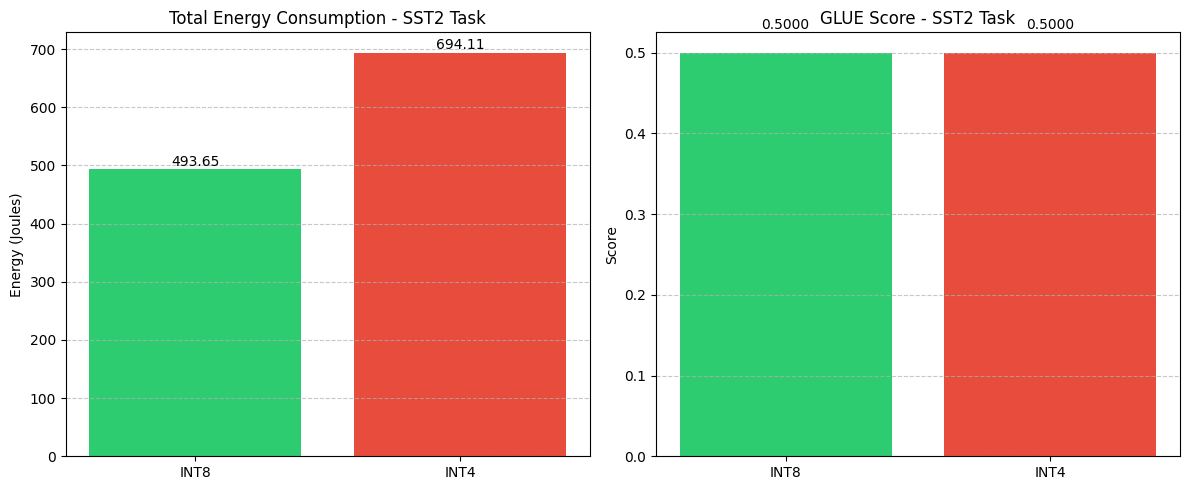

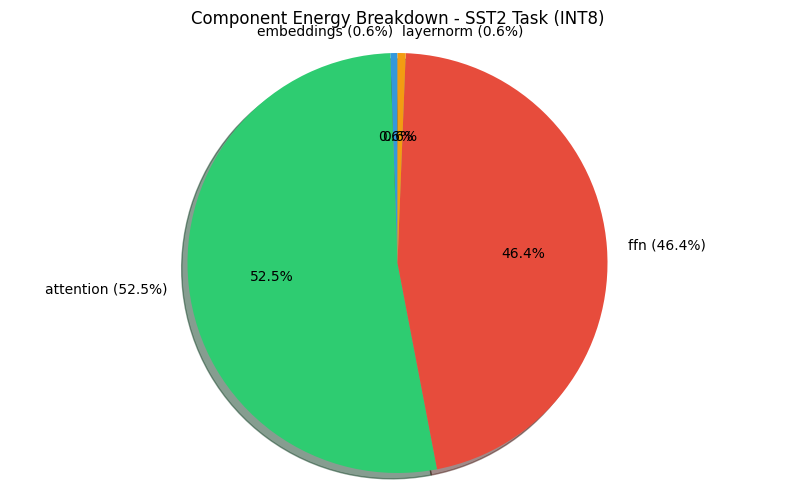

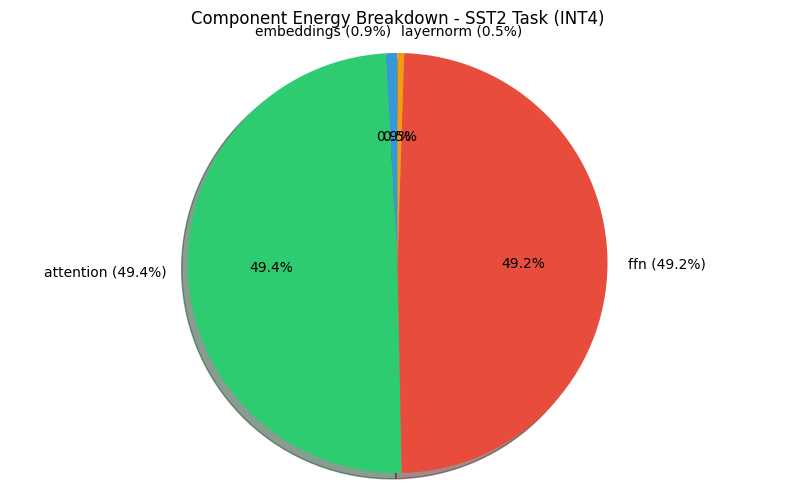

{'sst2': {'int8': {'task': 'sst2',
   'glue_score': 0.5,
   'total_energy': 493.6459999998915,
   'energy_per_token': 1.0284291666664407,
   'throughput': 52.15629287737328,
   'total_time': 9.203108072280884,
   'total_tokens': 480,
   'component_energy': {'embeddings': 3.2358207805156707,
    'attention': 307.8890423270283,
    'ffn': 272.0061959060663,
    'layernorm': 3.6667682304382323,
    'output_layer': 0.0},
   'carbon_emissions': 57.1806616666541,
   'energy_savings': 28.880622495917642},
  'int4': {'task': 'sst2',
   'glue_score': 0.5,
   'total_energy': 694.1090000001132,
   'energy_per_token': 1.4460604166669024,
   'throughput': 50.31287752321803,
   'total_time': 9.540301084518433,
   'total_tokens': 480,
   'component_energy': {'embeddings': 8.08597039892664,
    'attention': 449.81224457510655,
    'ffn': 447.4687229082501,
    'layernorm': 4.616246213912963,
    'output_layer': 0.0},
   'carbon_emissions': 80.40095916667978}}}